Skeleton Code

In [22]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
import numpy as np
import time

In [23]:
# Function to download and load dataset
def load_data():
    page_url = 'https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones'
    page_response = requests.get(page_url)
    if page_response.status_code == 200:
        soup = BeautifulSoup(page_response.content, 'html.parser')
        download_link = soup.select_one('a[href$=".zip"]')['href']
        full_download_url = 'https://archive.ics.uci.edu' + download_link
        response = requests.get(full_download_url)
        if response.status_code == 200:
            with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
                inner_zip_name = 'UCI HAR Dataset.zip'
                with outer_zip.open(inner_zip_name) as inner_zip_file:
                    with zipfile.ZipFile(io.BytesIO(inner_zip_file.read())) as inner_zip:
                        with inner_zip.open('UCI HAR Dataset/train/X_train.txt') as myfile:
                            df = pd.read_csv(myfile, delim_whitespace=True, header=None)
                        with inner_zip.open('UCI HAR Dataset/train/y_train.txt') as myfile_y:
                            y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)
    else:
        raise Exception("Failed to download or parse the dataset.")
    return df, y


In [24]:
# Load dataset
df, y = load_data()

# TASK 1 - EDA
print("First few rows of the dataset:")
print(df.head())

<ipython-input-23-af53a6110993>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(myfile, delim_whitespace=True, header=None)


First few rows of the dataset:
        0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555       556       557      

<ipython-input-23-af53a6110993>:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)


In [25]:
# Task 2: Encode class labels
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y.values.ravel())

In [26]:
# Task 3: Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [27]:
# Task 4: Split the data into training and testing sets
X_train_full, X_test_full, y_train, y_test = train_test_split(df_scaled, encoded_y, test_size=0.2, random_state=42)

In [28]:
# Define a Pipeline with Gaussian Naive Bayes and train it on the full dataset
start_time = time.time()
classifier_pipeline_full = Pipeline([
    ('classifier', GaussianNB())
])
classifier_pipeline_full.fit(X_train_full, y_train)
y_pred_full = classifier_pipeline_full.predict(X_test_full)
end_time = time.time()
full_features_time = end_time - start_time
accuracy_full = accuracy_score(y_test, y_pred_full)

In [29]:
# Task 5: Perform K-Means clustering for dimensionality reduction
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(df_scaled)

KMeans(n_clusters=50, n_init=10, random_state=42)

In [30]:
selected_features_indices = [np.random.choice(np.where(kmeans.labels_ == i)[0]) for i in range(n_clusters)]
# Ensure selected_features_indices are within the bounds of df_scaled columns
selected_features_indices = [idx for idx in selected_features_indices if idx < df_scaled.shape[1]]
selected_features = df_scaled[:, selected_features_indices]

In [31]:
# Task 6: Split the data with reduced features for training and testing
X_train_reduced, X_test_reduced = train_test_split(selected_features, test_size=0.2, random_state=42)

In [32]:
# Task 7: Implement and train a NB model on the reduced feature set
start_time_reduced = time.time()
classifier_pipeline_reduced = Pipeline([
    ('classifier', GaussianNB())
])
classifier_pipeline_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = classifier_pipeline_reduced.predict(X_test_reduced)
end_time_reduced = time.time()
reduced_features_time = end_time_reduced - start_time_reduced
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

# Print accuracy and training time for both models
print("Baseline Model (All Features):")
print("Accuracy:", accuracy_full)
print("Training Time:", full_features_time, "seconds")
print("Number of Features:", X_train_full.shape[1])

print("\nModel with Reduced Features (K-Means):")
print("Accuracy:", accuracy_reduced)
print("Training Time:", reduced_features_time, "seconds")
print("Number of Features:", n_clusters)

Baseline Model (All Features):
Accuracy: 0.7314751869476547
Training Time: 0.18429350852966309 seconds
Number of Features: 561

Model with Reduced Features (K-Means):
Accuracy: 0.41332426920462273
Training Time: 0.0058825016021728516 seconds
Number of Features: 50


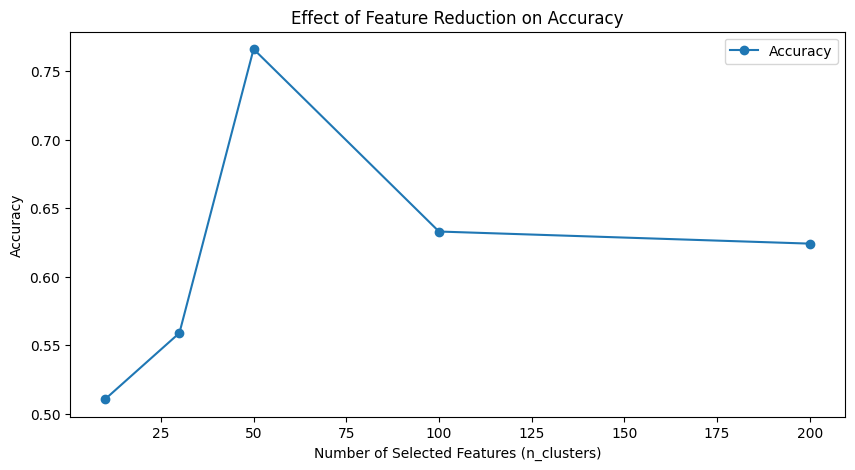

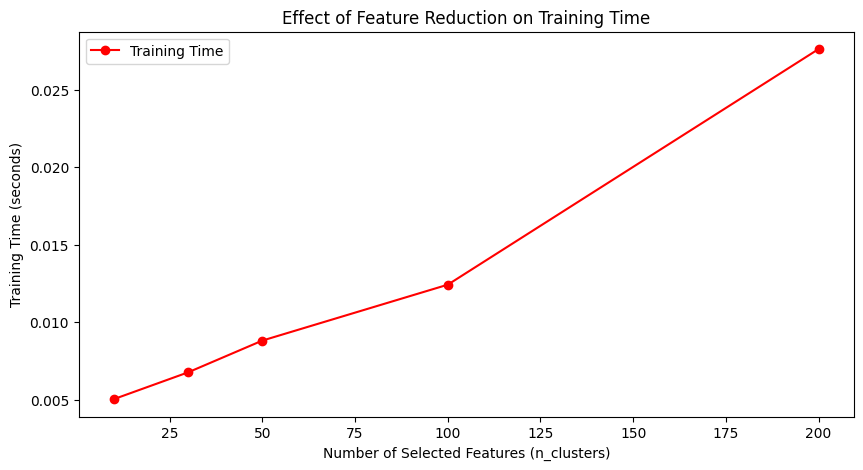

In [34]:
import matplotlib.pyplot as plt

# List of cluster values to test
cluster_sizes = [10, 30, 50, 100, 200]
accuracies = []
training_times = []

for n_clusters in cluster_sizes:
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    selected_features_indices = [np.random.choice(np.where(kmeans.labels_ == i)[0]) for i in range(n_clusters)]
# Get the feature indices instead of data point indices
    selected_features_indices = [np.random.choice(df_scaled.shape[1], size=1, replace=False)[0] for _ in range(n_clusters)]
# Ensure selected_features_indices are within the bounds of df_scaled columns
    selected_features_indices = [idx for idx in selected_features_indices if idx < df_scaled.shape[1]]
    selected_features = df_scaled[:, selected_features_indices]


    # Split the dataset
    X_train_reduced, X_test_reduced = train_test_split(selected_features, test_size=0.2, random_state=42)

    # Train a Naive Bayes model
    start_time = time.time()
    classifier_pipeline = Pipeline([('classifier', GaussianNB())])
    classifier_pipeline.fit(X_train_reduced, y_train)
    y_pred = classifier_pipeline.predict(X_test_reduced)
    end_time = time.time()

    # Store results
    accuracies.append(accuracy_score(y_test, y_pred))
    training_times.append(end_time - start_time)

# Plot Accuracy vs. Number of Features
plt.figure(figsize=(10, 5))
plt.plot(cluster_sizes, accuracies, marker='o', label="Accuracy")
plt.xlabel("Number of Selected Features (n_clusters)")
plt.ylabel("Accuracy")
plt.title("Effect of Feature Reduction on Accuracy")
plt.legend()
plt.show()

# Plot Training Time vs. Number of Features
plt.figure(figsize=(10, 5))
plt.plot(cluster_sizes, training_times, marker='o', color='r', label="Training Time")
plt.xlabel("Number of Selected Features (n_clusters)")
plt.ylabel("Training Time (seconds)")
plt.title("Effect of Feature Reduction on Training Time")
plt.legend()
plt.show()
